<a href="https://colab.research.google.com/github/Cyki89/Ja2_Faces_Generation/blob/master/Generating_Ja2_Faces_training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Import libraries and modules

In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import time
import os

# 2 Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# 3 Create helpers functions

In [0]:
def read_images(dir_path):
    ''' read each image from dir and put everything on the list '''  
    images = []
    
    for image in os.listdir(dir_path):
        images.append(Image.open(os.path.join(dir_path ,image)).convert("RGB"))
    
    return images

def norm(image):
    ''' normalize images to the range (-1,1) '''
    return ( (image-127.5)/127.5 ).astype('float32')

def denorm(image):
    ''' denormalize images to the range (0, 255) '''
    return ( image*127.5+127.5 ).astype('uint8')


def print_real_images(images, rows, cols):
    ''' print real images in grid format '''
    plt.figure(figsize=(rows, cols))
    gs1 = gs.GridSpec(rows, cols)
    gs1.update(wspace=0, hspace=0)

    for i in range(rows*cols):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        fig = plt.imshow(images[i])
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
    plt.tight_layout()
    
    plt.show()


def print_augumented_image(images, rows, cols):
    ''' print augumented images in grid format '''
    plt.figure(figsize=(rows, cols))
    gs1 = gs.GridSpec(rows, cols)
    gs1.update(wspace=0, hspace=0)

    for i in range(rows*cols):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        augumented_image=denorm(images[i])
        fig = plt.imshow(augumented_image)
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
    plt.tight_layout()
    
    plt.show()


def print_and_save_fake_images(generator, noise, rows, cols, epoch, img_dir='/content/drive/My Drive/Images', verbose=1):
    ''' print and save generated images '''
    plt.figure(figsize=(rows, cols))
    gs1 = gs.GridSpec(rows, cols)
    gs1.update(wspace=0, hspace=0)
    generated_images = generator.predict(noise)

    for i in range(rows*cols):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = generated_images[i]
        image = denorm(image).astype('int')
        fig = plt.imshow(image)
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
    plt.tight_layout()

    plt.savefig(os.path.join(img_dir, str(epoch).zfill(6) + "_generated_images.png"),
                bbox_inches='tight', 
                pad_inches=0)
        
    if verbose:
        plt.show()
    plt.close()

# 4 Define training environment

In [0]:
# Images properties
WIDTH = 96
HEIGHT = 96
CHANELS = 3
IMAGE_SHAPE = (HEIGHT, WIDTH, CHANELS)

# Training set properties
BATCH_SIZE = 64
SEED_SIZE = 100

# Image printing properties
ROWS = 8
COLS = 8

# Training properties
EPOCHS = 100000 # interup training after 65000 epochs

# 5 Create functions to build Generator, Discriminator and GAN

In [0]:
def build_discriminator(image_shape):
    ''' build and complie discriminator model '''

    # image shape: 96, 96, 3
    model = Sequential()

    # downsampling to the shape: 48, 48, 128
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    # downsampling to the shape: 24, 24, 258
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same")) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    # flatten array 
    model.add(Flatten())

    # classify image as fake or real
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(1.5e-4, 0.5), 
                  metrics=['accuracy'])
    
    print(model.summary())

    return model


def build_generator(seed_size):
    ''' build and complie generator model '''

    # seed size: 100
    model = Sequential()

    # first layers output shape: 24, 24, 256
    model.add(Dense(24*24*256,activation="relu", input_dim=seed_size))
    model.add(Reshape((24,24,256))) 

    # upsampling to the shape: 48, 48, 256
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # upsampling to the shape: 96, 96, 256
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # output layer shape: 96, 96, 3
    model.add(Conv2D(3, kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    print(model.summary())

    return model


def build_gan(generator, discriminator):
    ''' merge generator and discrimator and compile model '''

    # define GAN optimizer
    optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)
    
    # merge generator and discriminator model
    generator_input = Input(shape=SEED_SIZE)
    gan_input = generator(generator_input)
    gan_output = discriminator(gan_input)
    
    gan = Model(generator_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    print(gan.summary())
    
    return gan

# 6 Create Generator, Discriminator and GAN or load existing models

In [0]:
try:
  discriminator = load_model("/content/drive/My Drive/Models/DISCRIMINATOR.h5")
  generator = load_model("/content/drive/My Drive/Models/GENERATOR.h5")
  gan = load_model("/content/drive/My Drive/Models/GAN.h5")
  print('Models loaded successfully...')
  
except OSError:
  print('Create new models...')
  
  # image shape: 96, 96, 3
  discriminator = build_discriminator(image_shape=IMAGE_SHAPE)

  # seed size: 100
  generator = build_generator(seed_size=SEED_SIZE)

  # keep discriminator’s parameters constant for generator training (GAN)
  discriminator.trainable = False

  # build and Compile GAN model with fixed Discriminator to train the Generator
  gan = build_gan(generator, discriminator)

Models loaded successfully...


In [0]:
# show generator architecture
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 147456)            14893056  
_________________________________________________________________
reshape (Reshape)            (None, 24, 24, 256)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 256)       590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 48, 48, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 96, 96, 256)      

In [0]:
# show discriminator architecture
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 256)       295168    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 589824)            0

# 7 Load images

After exctract faces from game files (see description in Readme) and several tries I selected two best types of images to GAN training:
- MERC men's faces in resolution 48 x 43
- NPC men's faces in resolution 106 x 122

## 7.1 Read NPC faces and resize them to 96 x 96 pixels

Orginal NPC faces:


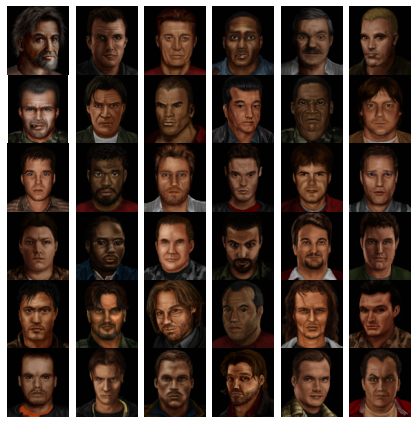

Shape of NPC faces dataset:(50, 96, 96, 3)


In [0]:
# load images
image_dir_npc = '/content/drive/My Drive/NPC_Faces'
images_npc = read_images(image_dir_npc)

# show examples of original faces from this dataset
print('Orginal NPC faces:')
print_real_images(images_npc, 6, 6)

# resize to 96 x 96 pixels and convert to numpy array
images_npc = [img.resize( (HEIGHT, WIDTH),Image.ANTIALIAS) for img in images_npc]
images_npc = np.array([np.asarray(img) for img in images_npc], dtype='uint8')

# show shape of dataset
print(f'Shape of NPC faces dataset:{images_npc.shape}')

## 7.2 Read MERC faces, resize them to 96 x 96 pixels and zoom out zoom out a little bit

Orginal MERC faces:


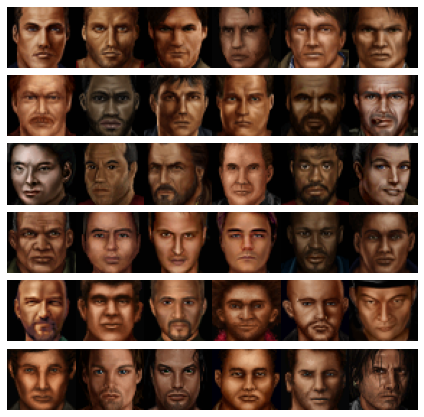

Transformed MERC faces:


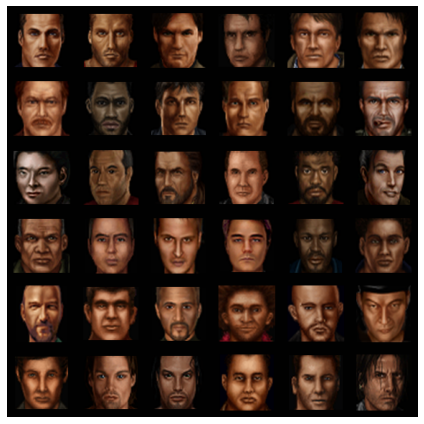

Shape of MERC faces dataset:(80, 96, 96, 3)


In [0]:
# load images
image_dir_merc = '/content/drive/My Drive/MERC_Faces'
images_merc_raw = read_images(image_dir_merc)

# show examples of original faces from this dataset
print('Orginal MERC faces:')
print_real_images(images_merc_raw, 6, 6)

# resize to 96 x 96 pixels and convert to numpy array
images_merc_raw = [img.resize( (HEIGHT, WIDTH),Image.ANTIALIAS) for img in images_merc_raw]
images_merc_raw = np.array([np.asarray(img) for img in images_merc_raw], dtype='uint8')


''' zoom out images usinng Keras ImageDataGenerator'''

# create generator for zooming out images
datagen = ImageDataGenerator(zoom_range=[1.2, 1.3],
                             fill_mode='constant',
                             cval=1)

# create placeholder for zooming out images
images_merc = []

for i in range(images_merc_raw.shape[0]):

  # transform the image into the right shape 
  sample = np.expand_dims(images_merc_raw[i], 0)
 
  # prepare iterator
  it = datagen.flow(sample, batch_size=1)
  
  # append zooming out image
  images_merc.append(it.next()[0])

# convert list to numpy array
images_merc = np.array(images_merc)

# show transformed images
print('Transformed MERC faces:')
print_augumented_image(norm(images_merc), 6, 6)

# show shape of dataset
print(f'Shape of MERC faces dataset:{images_merc.shape}')

## 7.3 Load an existing image data set or combine MERC and NPC images to create a new one

Successfully loaded image dataset ...

 Example images from dataset:


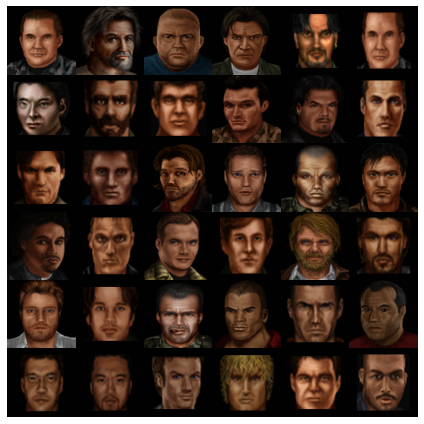

Image dataset shape: (130, 96, 96, 3)


In [0]:
try:
    with open('/content/drive/My Drive/Datasets/images_dataset.pickle', 'rb') as f:
        images = pickle.load(f).astype('uint8')
        
    print('Successfully loaded image dataset ...')

except OSError:
    print('Create new dataset...')
    images = np.concatenate((images_merc, images_npc), 0)
    
    # create random sample indexes
    rng = list( range( len(images) ) )
    np.random.shuffle(rng)
    
    # shuffle images
    images = images[rng]
    
    # save image dataset for future use
    with open('/content/drive/My Drive/Datasets/images_dataset.pickle', 'wb') as f:
        pickle.dump(images, f, pickle.HIGHEST_PROTOCOL)


# print example images
print('\n','Example images from dataset:')
print_augumented_image(norm(images), 6, 6)    
    
# check image dataset shape
print(f'Image dataset shape: {images.shape}')

As you can see I have only 130 good quality images ... future image augmentation will be needed.

# 8 Create or load previously saved fixed noise to see GAN learning progress

In [0]:
try:      
    with open('/content/drive/My Drive/Datasets/fixed_seed.pickle', 'rb') as f:
        fixed_seed = pickle.load(f)     

except OSError:
    print('Create new fixed seed...')
    fixed_seed = np.random.uniform(-1, 1, (ROWS * COLS, SEED_SIZE))
    
    # save fixed noise for future use
    with open('/content/drive/My Drive/Datasets/fixed_seed.pickle', 'wb') as f:
        pickle.dump(fixed_seed, f, pickle.HIGHEST_PROTOCOL)

 # 9 Create or load placeholders to monitoring GAN losses

In [0]:
try:
    with open('/content/drive/My Drive/Losses/discriminator_losses.pickle', 'rb') as f:
        discriminator_losses = pickle.load(f)

    with open('/content/drive/My Drive/Losses/generator_losses.pickle', 'rb') as f:
        generator_losses = pickle.load(f)

    print('Successfully loaded loss placeholders...')

except OSError:
    print('Create loss placeholders...')
    
    # create placeholders for model losses
    discriminator_losses = []
    generator_losses = []

    # save placesholders for future use
    with open('/content/drive/My Drive/Losses/discriminator_losses.pickle', 'wb') as f:
        pickle.dump(discriminator_losses, f, pickle.HIGHEST_PROTOCOL)

    with open('/content/drive/My Drive/Losses/generator_losses.pickle', 'wb') as f:
        pickle.dump(generator_losses, f, pickle.HIGHEST_PROTOCOL)

Successfully loaded loss placeholders...


 # 10 Create image data augmentation generator

In [0]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             brightness_range=[0.8, 1.8],
                             height_shift_range=0.05,
                             width_shift_range=0.1,
                             rotation_range=3,
                             shear_range=2,
                             channel_shift_range=10,
                             # normalize data to the range(-1,1)
                             preprocessing_function=norm)

# 11 Create GAN training loop

Augumented images


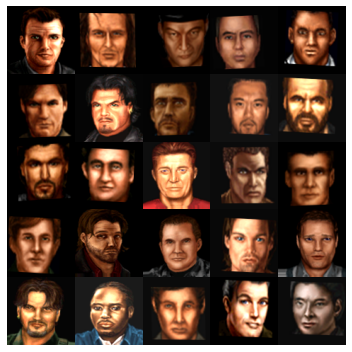

Fake images


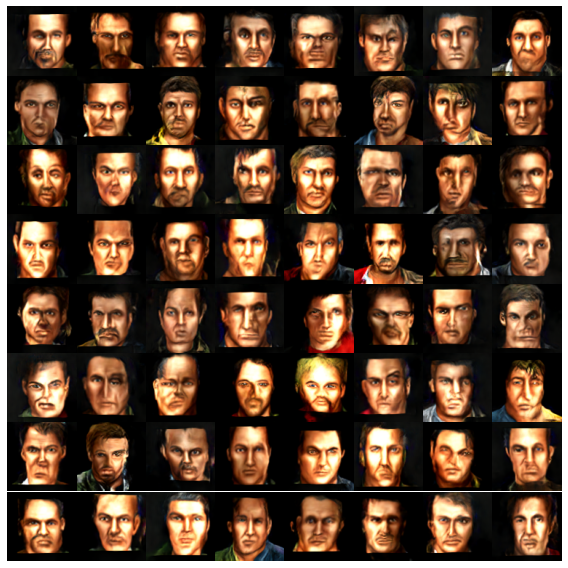

In [0]:
START_EPOCH = len(generator_losses)
END_EPOCH = START_EPOCH + EPOCHS

for epoch in range(START_EPOCH, END_EPOCH):
      
    # get a random batch of real images
    idx = np.random.randint(0, images.shape[0], int(BATCH_SIZE/2) )
    real_images_X = images[idx]

    # prepare iterator for image batch on each epoch
    it = datagen.flow(real_images_X, batch_size=int(BATCH_SIZE/2) )
    real_images_X = it.next()

    # generate a batch of fake images
    noise = np.random.uniform(-1, 1, (int(BATCH_SIZE/2), SEED_SIZE))
    fake_images_X = generator.predict(noise)

    # concatenate real and fake images
    all_images_X = np.concatenate( (real_images_X, fake_images_X), axis=0 )

    # # add noise to the label inputs to improve GAN learning
    real_images_y = np.ones( int(BATCH_SIZE/2) ) - np.random.random_sample( int(BATCH_SIZE/2) ) * 0.1
    fake_images_y = np.random.random_sample( int(BATCH_SIZE/2) ) * 0.1

    # concatenate images and their labels
    all_images_X = np.concatenate( (real_images_X, fake_images_X), axis=0 )
    all_images_y = np.concatenate( (real_images_y, fake_images_y), axis=0 )

    # create random sample indexes
    rng = list( range( len(all_images_X) ) )
    np.random.shuffle(rng)

    # shuffle sample order
    all_images_X = all_images_X[rng]
    all_images_y = all_images_y[rng]

    
    ''' Training the Discriminator'''

    # keep discriminator’s weights trainable for discriminator training
    discriminator.trainable = True
    
    # update weights on single batch
    discriminator_loss = discriminator.train_on_batch(all_images_X, all_images_y)
    discriminator_losses.append(discriminator_loss[0])

    
    ''' Training the Generator '''  
    
    # keep discriminator’s weights constant for generator training
    discriminator.trainable = False

    # create random noise and smoothed labels for generator training
    gan_X = np.random.uniform(-1, 1, (BATCH_SIZE, SEED_SIZE)) 
    gan_y = np.ones(BATCH_SIZE) - np.random.random_sample(BATCH_SIZE) * 0.1

    # update weights on single batch
    gan_metrics = gan.train_on_batch(gan_X, gan_y)
    generator_losses.append(gan_metrics[0])
    
    # monitoring gan learning progress
    if (epoch % 100) == 0:
        print( (f'Epoch: {epoch+1} ' 
              f'discriminator loss={np.round(discriminator_losses[-1], 4)} ' 
              f'generator loss={np.round(generator_losses[-1], 4)}') )

        # show agumented images for each bacth
        print('Augumented images')
        print_augumented_image(real_images_X, 5, 5)

        print('Fake images')
        print_and_save_fake_images(generator, 
                                   fixed_seed, 
                                   ROWS, 
                                   COLS, 
                                   epoch+1, 
                                   img_dir='/content/drive/My Drive/Images', 
                                   verbose=1)
        
        # overwrite models every few epochs 
        if (epoch % 2000) == 0:
            
            # save models
            discriminator.trainable = True
            generator.trainable = True
            generator.save(f"/content/drive/My Drive/Models/GENERATOR.h5")
            discriminator.save(f"/content/drive/My Drive/Models/DISCRIMINATOR.h5")
            gan.save(f"/content/drive/My Drive/Models//GAN.h5")
            
            # save generator training history
            with open('/content/drive/My Drive/Losses/generator_losses.pickle', 'wb') as f:
                pickle.dump(generator_losses, f, pickle.HIGHEST_PROTOCOL)

            # save discriminator training history
            with open('/content/drive/My Drive/Losses/discriminator_losses.pickle', 'wb') as f:
                pickle.dump(discriminator_losses, f, pickle.HIGHEST_PROTOCOL)

Above there are:
- example of augumented data batch 
- generated images after 65000 epochs

# 11 Show GAN training history

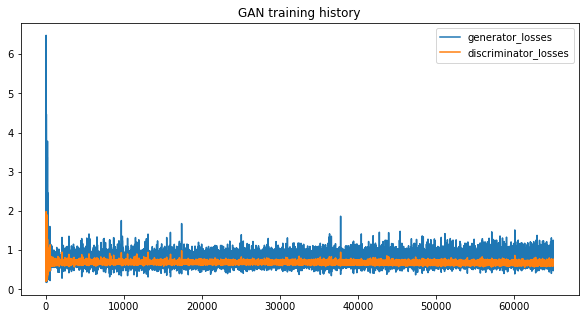

In [0]:
plt.figure(figsize=(10,5))
plt.title('GAN training history')
plt.plot(generator_losses, label='generator_losses')
plt.plot(discriminator_losses, label='discriminator_losses')
plt.legend()
plt.show()


As you can see after several dozen epochs, the loss of the generator and discriminator stabilized, but the quality of images continued to increase